In [1]:
import os
import math
import json
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow.keras as keras
import tensorflow as tf


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def load_data_from_npz(dataset_path, data1, data2):
    npzfile = np.load(dataset_path)
    return npzfile[data1], npzfile[data2]

In [4]:
def prepare_datasets(data_path, test_size, validation_size):
    
    # load data
    X, y = load_data_from_npz(data_path, 'mfcc', 'labels')
    
    # create train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    
    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, 
                                                                    y_train, 
                                                                    test_size=validation_size)
    
    
    X_train = X_train[..., np.newaxis] # 4d array -> (num_samples, 130, 13, 1)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test
    

In [5]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets('../data/data.npz', 0.25, 0.2)

In [67]:
def build_model(input_shape):
    # create model
    model = keras.Sequential()
    
    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    
    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # flatten the output and feed into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(32, activation='relu'))
    
    
    # output layer (softmax)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model
    
    

In [68]:
X_train.shape

(5997, 130, 13, 1)

In [69]:
# build CNN model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

In [70]:
# compile model
optimizer = keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [71]:
history = model.fit(X_train, 
          y_train, 
          validation_data=(X_validation, y_validation), 
          batch_size=64, 
          epochs=100)

Train on 5997 samples, validate on 1500 samples
Epoch 1/100
5997/5997 [==============================] - 1s 163us/sample - loss: 2.5348 - accuracy: 0.1504 - val_loss: 2.1293 - val_accuracy: 0.2287
Epoch 2/100
5997/5997 [==============================] - 0s 62us/sample - loss: 2.1746 - accuracy: 0.2485 - val_loss: 1.9024 - val_accuracy: 0.3393
Epoch 3/100
5997/5997 [==============================] - 0s 61us/sample - loss: 2.0121 - accuracy: 0.2925 - val_loss: 1.7585 - val_accuracy: 0.4013
Epoch 4/100
5997/5997 [==============================] - 0s 71us/sample - loss: 1.8929 - accuracy: 0.3295 - val_loss: 1.6524 - val_accuracy: 0.4387
Epoch 5/100
5997/5997 [==============================] - 0s 63us/sample - loss: 1.8026 - accuracy: 0.3618 - val_loss: 1.5695 - val_accuracy: 0.4627
Epoch 6/100
5997/5997 [==============================] - 0s 59us/sample - loss: 1.7460 - accuracy: 0.3802 - val_loss: 1.4918 - val_accuracy: 0.4807
Epoch 7/100
5997/5997 [==============================] - 0s 59u

5997/5997 [==============================] - 0s 62us/sample - loss: 0.7996 - accuracy: 0.7219 - val_loss: 0.7731 - val_accuracy: 0.7273
Epoch 56/100
5997/5997 [==============================] - 0s 62us/sample - loss: 0.7968 - accuracy: 0.7249 - val_loss: 0.7289 - val_accuracy: 0.7493
Epoch 57/100
5997/5997 [==============================] - 0s 63us/sample - loss: 0.7903 - accuracy: 0.7290 - val_loss: 0.8055 - val_accuracy: 0.7187
Epoch 58/100
5997/5997 [==============================] - 0s 62us/sample - loss: 0.7873 - accuracy: 0.7279 - val_loss: 0.7918 - val_accuracy: 0.7240
Epoch 59/100
5997/5997 [==============================] - 0s 62us/sample - loss: 0.8091 - accuracy: 0.7204 - val_loss: 0.7327 - val_accuracy: 0.7507
Epoch 60/100
5997/5997 [==============================] - 0s 61us/sample - loss: 0.7506 - accuracy: 0.7382 - val_loss: 0.7231 - val_accuracy: 0.7573
Epoch 61/100
5997/5997 [==============================] - 0s 59us/sample - loss: 0.7857 - accuracy: 0.7329 - val_loss: 

In [72]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)


2499/2499 [==============================] - 0s 58us/sample - loss: 0.6630 - accuracy: 0.7711


In [76]:
X = X_test[300]
y = y_test[300]

In [77]:
def predict(model, X, y):
    
    # need to add the 4th dimension for the model
    X = X[np.newaxis, ...]
    
    # prediction is a 2d array
    predictions = model.predict(X)
    
    predicted_index = np.argmax(predictions, axis=1)
    
    return predicted_index, predictions
    
    

In [78]:
prediction, nList = predict(model, X, y)

In [79]:
prediction

array([0], dtype=int64)

In [80]:
nList

array([[9.9598122e-01, 1.2833744e-06, 2.3866212e-03, 1.1366664e-04,
        8.9180713e-07, 1.3592165e-03, 4.5687157e-06, 1.5062677e-04,
        1.1415101e-06, 5.8823326e-07]], dtype=float32)

In [81]:
y

0

In [75]:
model.save('../models/cnn_model_77acc_lr15.h5')

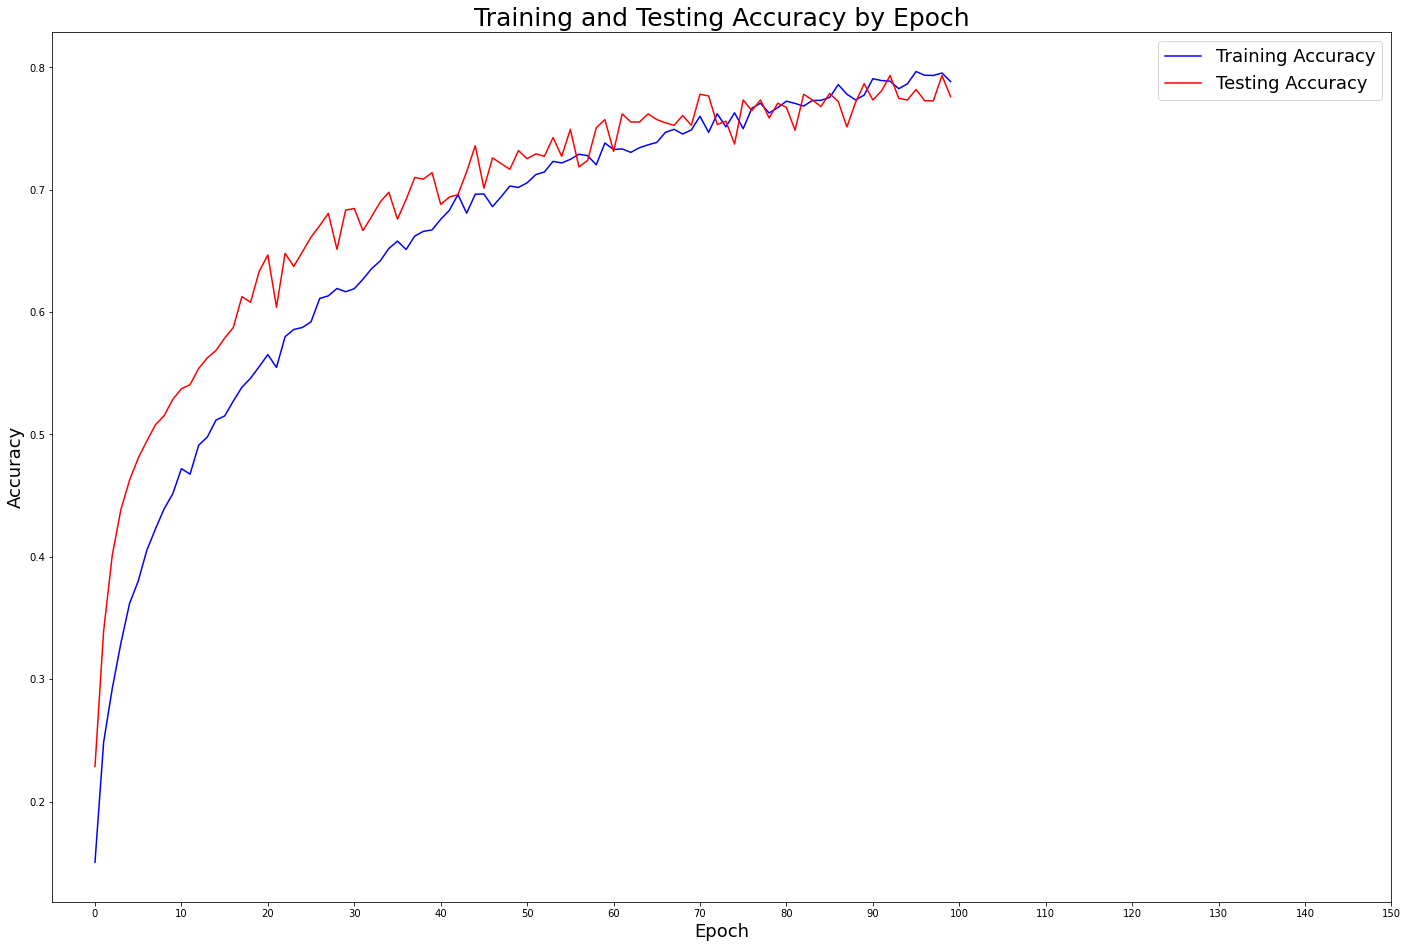

In [73]:
# Check out our train accuracy and test accuracy over epochs.
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(24, 16))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='blue')
plt.plot(test_loss, label='Testing Accuracy', color='red')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(range(0,160, 10), range(0,160, 10))

plt.legend(fontsize = 18);

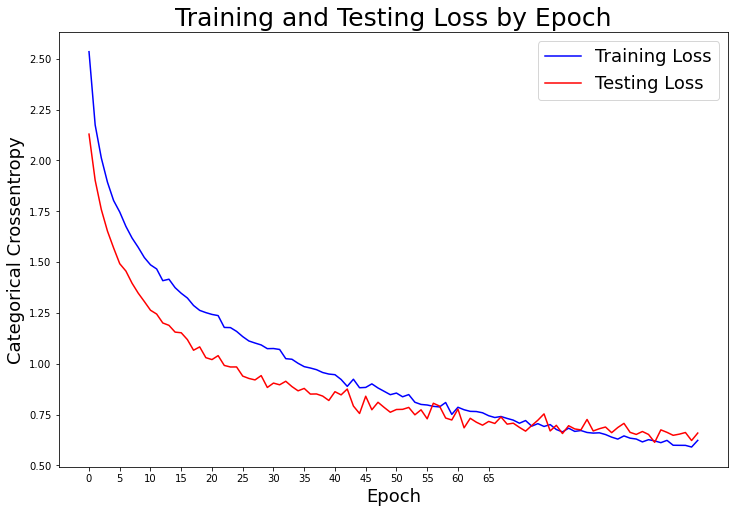

In [74]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,70, 5), range(0,70, 5))

plt.legend(fontsize = 18);